In [49]:
from dotenv import load_dotenv
import os
from collections import defaultdict

load_dotenv()

if os.getenv("GROQ_API_KEY"):
    print('Groq API Key loaded successfully')
else:
    print('Groq API Key loading failed, please make sure the .env file exists and the spelling is correct')

if os.getenv("TAVILY_API_KEY"):
    print('Tavily API Key loaded successfully')
else:
    print('Tavily API Key loading failed, please make sure the .env file exists and the spelling is correct')

Groq API Key loaded successfully
Tavily API Key loaded successfully


In [50]:
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_groq import ChatGroq
import random

from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

load_dotenv()

chat_model = ChatGroq(
    model="llama-3.1-70b-versatile",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

## Class for Game Logic

In [51]:
class Game:

    def __init__(self):
        self.board = self.initialize_board()
        self.red_words = [key for key, value in self.board.items() if value == "red"]
        self.blue_words = [key for key, value in self.board.items() if value == "blue"]
        self.black_words = [key for key, value in self.board.items() if value == "black"]
        self.neutral_word = [key for key, value in self.board.items() if value == "neutral"]
        self.has_turn = "RED"
        self.winner = None
        self.last_spymaster_answer = None
        self.rounds = 0
        self.guessed_words = set()
        self.max_guesses = 1 # number of words to guess. Updated at every new spymaster clue
        self.current_guess_counter = 0
        self.right_guesses = 0
        self.wrong_guesses = 0
        self.export = {'red':[], 'blue':[]}
        
        self.current_turn = None

    def initialize_board(self):
        word_list = self.load_words()
        board_words = random.sample(word_list, 25)
        colors = ["red"] * 9 + ["blue"] * 8 + ["neutral"] * 7 + ["black"] * 1
        random_state = 42
        random.shuffle(colors)
        board = dict(zip(board_words, colors))
        return board
    
    def load_words(self):
        with open('baseline_words.txt', 'r') as file:
            words = [line.strip() for line in file]
            return words


## Tool Preparation

In [52]:
from typing import Optional, Type

from langchain.callbacks.manager import (
    AsyncCallbackManagerForToolRun,
    CallbackManagerForToolRun,
)
from langchain.pydantic_v1 import BaseModel, Field, PrivateAttr
from langchain.tools import BaseTool, StructuredTool, tool


class GuessInput(BaseModel):
    query: str = Field(description="should be a single word from the game-board")

class GuessTool(BaseTool):
    name: str = "codenames_guess_tool"
    description: str = "essential to guess words from the game-board"
    args_schema: Type[BaseModel] = GuessInput
    game: Game = PrivateAttr()

    def __init__(self, game):
        super().__init__()
        # Store the game object as an instance variable
        self.game = game

    def __call__(self, query: str) -> str:
        """Allows the tool to be callable directly."""
        return self._run(query)

    def _run(
        self, query: str, run_manager: Optional[CallbackManagerForToolRun] = None
    ) -> str:
        """Use the tool with context from the game object."""
        query = query.upper()
        if query in self.game.board.keys() and query not in self.game.guessed_words:
            self.game.guessed_words.add(query)
            return self.game.board[query]
        else:
            return f"WRONG: {query}"

    async def _arun(
        self, query: str, run_manager: Optional[AsyncCallbackManagerForToolRun] = None
    ) -> str:
        """Use the tool asynchronously with context from the game object."""
        raise NotImplementedError("custom_game_tool does not support async")
    

class DiscussInput(BaseModel):
    query: str = Field(description="should be the message for the teammembers")

class DiscussTool(BaseTool):
    name: str = "codenames_discuss_tool"
    description: str = "essential to communicate with your teammembers"
    args_schema: Type[BaseModel] = DiscussInput

    def __init__(self):
        super().__init__()

    def __call__(self, query: str) -> str:
        """Allows the tool to be callable directly."""
        return self._run(query)

    def _run(
        self, query: str, run_manager: Optional[CallbackManagerForToolRun] = None
    ) -> str:
        """Use the tool to communicate with your teammembers, the query is the message."""
        return query    

    async def _arun(
        self, query: str, run_manager: Optional[AsyncCallbackManagerForToolRun] = None
    ) -> str:
        """Use the tool asynchronously with context from the game object."""
        raise NotImplementedError("custom_game_tool does not support async")
    

#class RefrainTool(BaseTool):
    #name: str = "codenames_refrain_tool"
    #description: str = "essential to refrain from interacting to let your teammembers interact"
    #args_schema: Type[BaseModel] = DiscussInput

    #def __init__(self):
     #   super().__init__()

    #def __call__(self, query="") -> str:
    #    """Allows the tool to be callable directly."""
    #    return self._run(query)

    #def _run(
    #    self, query, run_manager: Optional[CallbackManagerForToolRun] = None
    #) -> str:
      #  """Use the tool to refrain from interaction, to let your teammembers interact."""
     #   if query:
       #     return query
      #  else:
      #      return "Has refrained from interaction."    

    async def _arun(
        self, query: str, run_manager: Optional[AsyncCallbackManagerForToolRun] = None
    ) -> str:
        """Use the tool asynchronously with context from the game object."""
        raise NotImplementedError("custom_game_tool does not support async")
    

class EndTurnTool(BaseTool):
    name: str = "codenames_end_turn_tool"
    description: str = "essential to end turn before spending all available guesses, for high uncertainty and risk mitigation"
    args_schema: Type[BaseModel] = None

    def __init__(self):
        super().__init__()

    def __call__(self, query="") -> str:
        """Allows the tool to be callable directly."""
        return self._run(query)

    def _run(
        self, query, run_manager: Optional[CallbackManagerForToolRun] = None
    ) -> str:
        """Use the tool to end your turn if you have guessed all words with a obvious relation to the clue"""
        if query:
            return query
        else:
            return "Has ended turn preemptively."    

    async def _arun(
        self, query: str, run_manager: Optional[AsyncCallbackManagerForToolRun] = None
    ) -> str:
        """Use the tool asynchronously with context from the game object."""
        raise NotImplementedError("custom_game_tool does not support async")

## Agent Class

In [53]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

class Agent:
    
    def __init__(self, models: dict[str, dict[str, ChatGroq]], game: Game, team_size=1, tools=None, max_rounds=1):
        self.game = game
        self.models = models
        self.team_size = team_size
        self.last_message_id = None
        self.max_rounds = max_rounds
        self.end_turn = False
        self.current_guesser_red = 2
        self.current_guesser_blue = 2

        graph = StateGraph(AgentState)

        # Setting up the nodes for the state graph
        graph.add_node("spymaster_red", self.call_red_spymaster)
        graph.add_node("spymaster_blue", self.call_blue_spymaster)
        graph.add_node("teammember_red", self.call_red_guesser)
        graph.add_node("teammember_blue", self.call_blue_guesser)
        graph.add_node("action_red", self.take_action)
        graph.add_node("action_blue", self.take_action)

        # Conditional edges based on game state
        graph.add_conditional_edges(
             "action_blue",
             self.define_next_player,
             {0: END, 1: "spymaster_red", 2: "teammember_blue"}
        )
        graph.add_conditional_edges(
             "action_red",
             self.define_next_player,
             {0: END, 1: "spymaster_blue", 2: "teammember_red"}
        )

        # Add edges for turn transitions
        graph.add_edge("spymaster_red", "teammember_red")
        graph.add_edge("spymaster_blue", "teammember_blue")
        graph.set_entry_point("spymaster_red")

        # Conditional edges that check for presence of tool call otherwise invoke next team member (see this as a fail safe)
        graph.add_conditional_edges(
            "teammember_red",
            self.exists_tool_call,
            {True: "action_red", False: "teammember_red"}
        )
        graph.add_conditional_edges(
            "teammember_blue",
            self.exists_tool_call,
            {True: "action_blue", False: "teammember_blue"}
        )
        
        # Compile graph to LangChain Runnable
        self.graph = graph.compile()
        
        # Bind tools to team member models if applicable
        self.tools = {t.name: t for t in tools}
        for name, model_dict in self.models.items():
            if "teammember" in name:
                model_dict["model"] = model_dict["model"].bind_tools(tools)


    def define_next_player(self, state: AgentState):
        exists_guess = self.exists_guess(state)
        game_end = self.check_game_end(state)
        if game_end:
            return 0
        elif exists_guess and (self.game.current_guess_counter >= self.game.max_guesses or self.end_turn):
            return 1
        else:
            return 2

    def exists_guess(self, state: AgentState):
        last_tool_messages = []
        messages = state['messages']
        index = len(messages) - 1

        while index >= 0:
            message = messages[index]
            if isinstance(message, ToolMessage):
                last_tool_messages.append(message)
            else:
                # Stop if we encounter a non-ToolMessage type
                break
            index -= 1
        was_guessed = any(m.name == "codenames_guess_tool" for m in last_tool_messages)
        return was_guessed
    
    def exists_tool_call(self, state: AgentState):
        result = state['messages'][-1]
        print(f"Test:{result}")
        return len(result.tool_calls) > 0

            
    def call_red_spymaster(self, state: AgentState):
        return self._call_spymaster("RED", state)

    def call_blue_spymaster(self, state: AgentState):
        return self._call_spymaster("BLUE", state)

    def call_red_guesser(self, state: AgentState):
        #number = random.randint(1,self.team_size)
        self.current_guesser_red = self.current_guesser_red +1
        number = (self.current_guesser_red % self.team_size) +1
        return self._call_guesser("RED", number, state)

    def call_blue_guesser(self, state: AgentState):
        #number = random.randint(1,self.team_size)
        self.current_guesser_blue = self.current_guesser_blue+1
        number = (self.current_guesser_blue % self.team_size)  +1
        return self._call_guesser("BLUE", number, state)
    
    def check_game_end(self, state: AgentState):
        game_over = False
        if self.game.rounds > self.max_rounds:
            game_over = True
        game_ends_black = any(word in self.game.guessed_words for word in self.game.black_words)
        game_ends_red = all(word in self.game.guessed_words for word in self.game.red_words)
        game_ends_blue = all(word in self.game.guessed_words for word in self.game.blue_words)
        if game_ends_black or game_ends_red or game_ends_blue:
            game_over = True
        if game_ends_black:
            self.game.winner = "BLUE" if self.game.has_turn == "RED" else "RED"
        elif game_ends_red:
            self.game.winner = "RED"
        elif game_ends_blue:
            self.game.winner = "BLUE"
        
        if game_over:
            print(f"guessed_words: {', '.join(self.game.guessed_words)}")
            print(f"WINNER: {self.game.winner}")
            print(f"ROUNDS PLAYED: {self.game.rounds}")
            
            export = f"""WINNER: {self.game.winner} , 
            BOARD:  {self.game.board} , 
            Guesses RED:{self.game.export['red']} , 
            Guesses BLUE:{self.game.export['blue']} , 
            Right Guesses {self.game.right_guesses}, 
            Wrong Guesses {self.game.wrong_guesses}"""
            with open("output_game.txt", "w") as file:
                file.write(export)

            return True
        return False
    
    def take_action(self, state: AgentState):
        tool_calls = state.get('messages', [])[-1].tool_calls
        results = []        
        for t in tool_calls:
            if t["name"]=='codenames_guess_tool':
                if self.game.current_guess_counter >= self.game.max_guesses:
                    self.end_turn = True
                
                result = self.tools[t['name']].invoke(t['args'])
                guessed_word_color = result.lower()
                self.game.current_guess_counter = self.game.current_guess_counter + 1
                results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result))) 

                # Check the result to determine if the turn should end
                if guessed_word_color == self.game.has_turn.lower():
                    # Correct guess, team can continue if max_guesses not reached
                    self.game.right_guesses  = self.game.right_guesses +1
                    print(f"Correct! {t['args']} belongs to team {guessed_word_color}.")
                    # for export
                    isCorrect = "correct"
                elif guessed_word_color == "black":
                    #End game, other team wins
                    self.game.wrong_guesses = self.game.wrong_guesses +1
                    print(f"Black word guessed! {self.game.has_turn} loses.")
                    self.end_turn = True
                    # for export
                    isCorrect = "incorrect - black"
                
                elif guessed_word_color == "neutral":
                    # Neutral word, end turn
                    self.game.wrong_guesses = self.game.wrong_guesses +1
                    self.end_turn = True
                    print(f"Incorrect! {t['args']} is a {guessed_word_color} word.")
                    # for export
                    isCorrect = "incorrect - neutral"
                else:
                    # Opponent's word, end turn
                    self.game.wrong_guesses = self.game.wrong_guesses +1
                    self.end_turn = True
                    print(f"Incorrect! {t['args']} is a {guessed_word_color} word.")
                    # for export
                    isCorrect = "incorrect - opponent"

                # Export
                if len(self.game.export[self.game.has_turn.lower()]) == self.game.rounds:
                    self.game.export[self.game.has_turn.lower()][-1]['guesses'].append((t["args"]['query'],isCorrect))
                else:
                    self.game.export[self.game.has_turn.lower()].append(
                        {
                            'clue':self.game.last_spymaster_answer.content, 
                            'guesses':[(t["args"]['query'],isCorrect)]
                        }
                    )

                # End the turn if this was decided
                if self.end_turn:
                    break
                
            elif t["name"] == 'codenames_discuss_tool':
                result = self.tools[t['name']].invoke(t['args'])
                results.append(ToolMessage(id=self.last_message_id, tool_call_id=t['id'], name=t['name'], content=str(result)))
            elif t["name"]=='codenames_end_turn_tool':
                result = self.tools[t['name']].invoke(t['args'])
                results.append(ToolMessage(id=self.last_message_id, tool_call_id=t['id'], name=t['name'], content=str(result)))
                self.end_turn = True
            else:
                results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content="Invalid tool name, retry"))

           
        return {'messages': results}
    
    def _call_spymaster(self, team, state):
        # increase round counter only when red is spymaster (as red starts the game and therefore each round) 
        if team.lower() == 'red':
            self.game.rounds += 1
        self.game.current_guess_counter = 0
        self.end_turn = False
        self.game.has_turn = team.upper()
        round = self.game.rounds
        messages = state['messages']
        prompt = self.get_spymaster_prompt(team)
        model = self.models[f"spymaster_{team}"]["model"]
        message = model.invoke(prompt)
        message.id = f"{round}_spymaster_{team}"
        # Parse the hint number from the spymaster's message (assuming format "Word N")
        hint_text = message.content.split()
        self.game.max_guesses = int(hint_text[1]) if len(hint_text) > 1 and hint_text[1].isdigit() else 1
        #state['messages'].append(message)
        self.game.last_spymaster_answer = message
        self.game.current_turn = f"{round}_spymaster_{team}"
        print(f"{self.game.current_turn} hint: {self.game.last_spymaster_answer.content}")
        return {'messages': [message]}
    
    def _call_guesser(self, team, number, state):
        round = self.game.rounds
        messages = state['messages']
        prompt = self.get_guesser_prompt(team, number)[0].content
        
        # Retrieve spymaster's hint and prepare discussion string
        spymaster_message = self.get_message_by_id(messages, f"{round}_spymaster_{team}")
        spymaster_hint = f"Spymaster's hint: {spymaster_message if spymaster_message else 'No hint available'} \n"
        filtered_messages = [m for m in messages if m.id is not None and m.id.startswith(f"{round}_teammember_{team}")]
        current_discussion_string = "\n".join(f"{m.id[2:]} said: '{m.content.strip()}'" for m in filtered_messages if m.id is not None)
        if current_discussion_string == "":
            current_discussion_string = "No discussion has taken place yet."

        team_members = [f"teammember_{team}_{i + 1}" for i in range(self.team_size)]
        team_members.remove(f"teammember_{team}_{number}")
        team_members_string = f"Your team members are: {', '.join(team_members)}."
        you_string = f"You are teammember_{team}_{number}."
        self.last_message_id = f"{round}_teammember_{team}_{number}"

        guesses_this_round = self.game.export[team.lower()][-1]['guesses'] if len(self.game.export[team.lower()]) == round else []
        
        # Combine into new_prompt
        current_discussion_string = current_discussion_string.replace(f"teammember_{team}_{number} said:", "You said:")
        new_prompt_content = (
            prompt
            + "\n"
            + spymaster_hint
            + f"With this hint, these guesses were made: {guesses_this_round}\n"
            + you_string + "\n"
            + team_members_string + "\n"
            + f"\nThis is the current discussion with your Teammembers:"
            + "\n"
            + current_discussion_string
        )


        model = self.models[f"teammember_{team}_{number}"]["model"]
        message = model.invoke([new_prompt_content])  # Pass as a single-item list containing the BaseMessage instance
        
        # Set message ID and append
        #message.id = f"{round}_teammember_{team}_{number}"
        #state['messages'].append(message)
        print(f"GuessID: {round}_teammember_{team}_{number}")
        print(f"Current Discussion: \n {current_discussion_string}")
        print(f"Answer: \n {message.content}")  # Display prompt content for verification
        
        return {'messages': [message]}
        
    def get_spymaster_prompt(self, team):
        not_guessed_board = {k: v for k, v in self.game.board.items() if k not in self.game.guessed_words}
        relevant_words = [k for k, v in not_guessed_board.items() if v.lower() == team.lower()]
        bad_words = [k for k, v in not_guessed_board.items() if v.lower() != team.lower()]
        
        return [SystemMessage(content=self.models[f"spymaster_{team}"]["system"]
            + f"\nGood words: {', '.join(relevant_words)}\n"
            + f"Bad words: {', '.join(bad_words)}"
        )]
    
    def get_guesser_prompt(self, team, number):
        not_guessed_board = [k for k in self.game.board if k not in self.game.guessed_words]
        hint_word = self.game.last_spymaster_answer.content

        return [SystemMessage(content=self.models[f"teammember_{team}_{number}"]["system"]
            + f"\nWord list: {', '.join(not_guessed_board)}\n"
        )]
    
    def get_message_by_id(self, messages, target_id):
        for message in messages:
            if message.id == target_id:
                return message.content
        return None  # Return None if no message with the given id is found

## Prepare Models and System Prompts

In [54]:

def load_prompt_from_file(filename):
    with open(filename, 'r') as file:
        prompt = file.read()  # Reads the entire content of the file as a string
    return prompt


spymaster_system_prompt =  load_prompt_from_file('spymaster_system_prompt.txt')


teammember_system_prompt =  load_prompt_from_file('teammember_system_prompt.txt')


models = {
    "spymaster_RED": {"model": None, "system": spymaster_system_prompt},
    "spymaster_BLUE": {"model": None, "system": spymaster_system_prompt},
    "teammember_RED_1": {"model": None, "system": teammember_system_prompt},
    "teammember_BLUE_1": {"model": None, "system": teammember_system_prompt},
    "teammember_RED_2": {"model": None, "system": teammember_system_prompt},
    "teammember_BLUE_2": {"model": None, "system": teammember_system_prompt},
}

for name, model_dict in models.items():
    if "spymaster" in name:
        model_dict["model"] = ChatGroq(
        model="llama-3.1-70b-versatile",
        temperature=0,
        max_tokens=20,
        timeout=None,
        max_retries=2,
        )   
    else:
        model_dict["model"] = ChatGroq(
        model="llama-3.1-70b-versatile",
        temperature=0,
        max_tokens=None,
        timeout=None,
        max_retries=2,
        )



## Prepare the Game

In [55]:
game = Game()  
game_tool = GuessTool(game)
discuss_tool = DiscussTool()
#refrain_tool = RefrainTool()
end_turn_tool = EndTurnTool()
abot = Agent(models, team_size=2, game=game, tools=[game_tool, discuss_tool, end_turn_tool], max_rounds=15)
messages = [HumanMessage(content="Play a game of Codenames.")]


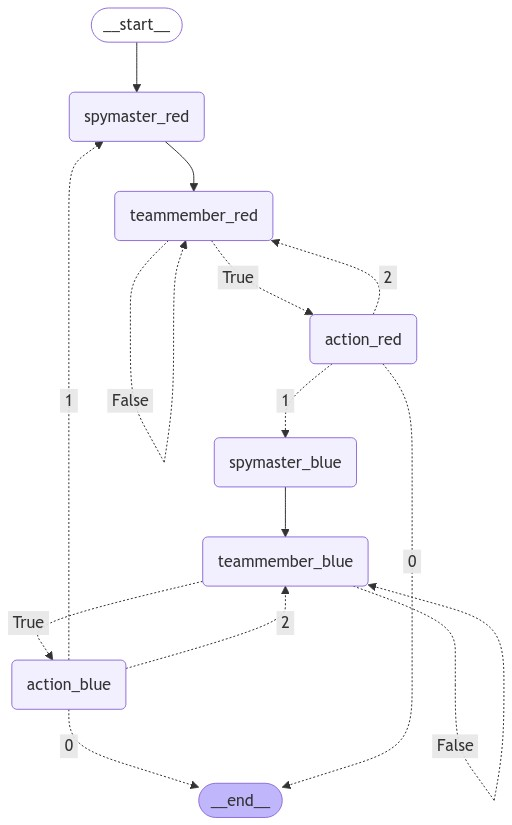

In [56]:
display(
    Image(
        abot.graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Execute Game

In [57]:
# Start the match
result = abot.graph.invoke({"messages": messages}, {"recursion_limit": 200})

1_spymaster_RED hint: Metal 2
GuessID: 1_teammember_RED_2
Current Discussion: 
 No discussion has taken place yet.
Answer: 
 
Test:content='' additional_kwargs={'tool_calls': [{'id': 'call_jadc', 'function': {'arguments': '{"query": "I think the hint Metal could relate to words like IRON or other metal-related words on the board. What do you think, teammember_RED_1?"}', 'name': 'codenames_discuss_tool'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 48, 'prompt_tokens': 740, 'total_tokens': 788, 'completion_time': 0.192, 'prompt_time': 0.123091382, 'queue_time': 0.0036431190000000002, 'total_time': 0.315091382}, 'model_name': 'llama-3.1-70b-versatile', 'system_fingerprint': 'fp_5c5d1b5cfb', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-94a3b74f-912e-465d-9e39-501de5b3212f-0' tool_calls=[{'name': 'codenames_discuss_tool', 'args': {'query': 'I think the hint Metal could relate to words like IRON or other metal-related words on the board. What do

In [58]:
result

{'messages': [HumanMessage(content='Play a game of Codenames.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Metal 2', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 4, 'prompt_tokens': 316, 'total_tokens': 320, 'completion_time': 0.016, 'prompt_time': 0.054120651, 'queue_time': 0.0035820010000000013, 'total_time': 0.070120651}, 'model_name': 'llama-3.1-70b-versatile', 'system_fingerprint': 'fp_b6828be2c9', 'finish_reason': 'stop', 'logprobs': None}, id='1_spymaster_RED', usage_metadata={'input_tokens': 316, 'output_tokens': 4, 'total_tokens': 320}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jadc', 'function': {'arguments': '{"query": "I think the hint Metal could relate to words like IRON or other metal-related words on the board. What do you think, teammember_RED_1?"}', 'name': 'codenames_discuss_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 48, 'prompt_tokens': 7